In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline


In [6]:
salary_df=pd.read_csv('data/glassdoor_eda.csv')
salary_df.columns


Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary',
       'average_salary', 'company_text', 'job_state', 'same_state',
       'company_age', 'python_yn', 'r_studio', 'spark', 'aws', 'excel',
       'title_simplified', 'seniority', 'desc_len', 'number_comp'],
      dtype='object')

In [7]:
model_df=salary_df[['Rating','Size', 'Type of ownership','Industry','Sector','Revenue','number_comp','hourly','employer_provided','job_state', 'same_state','company_age','python_yn', 'spark', 'aws', 'excel','title_simplified', 'seniority', 'desc_len', 'average_salary']].copy()

In [8]:
# get dummies
dum_df= pd.get_dummies(model_df)
dum_df.shape

(742, 178)

In [9]:
x=dum_df.drop(['average_salary'],axis=1)
print(x.shape)
y=dum_df['average_salary']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

(742, 177)


## Linear regressions

In [10]:

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, Binarizer

In [11]:
# Create a compact pipeline
pipeline_lm = make_pipeline(StandardScaler(), LinearRegression())

# Define cross-validation strategy
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate using cross-validation
results = cross_val_score(pipeline_lm, x, y, cv=kfold, scoring='neg_mean_absolute_error')

# Print the average error
print(results.mean())

-18.973777222430037


## looking for the best alpha

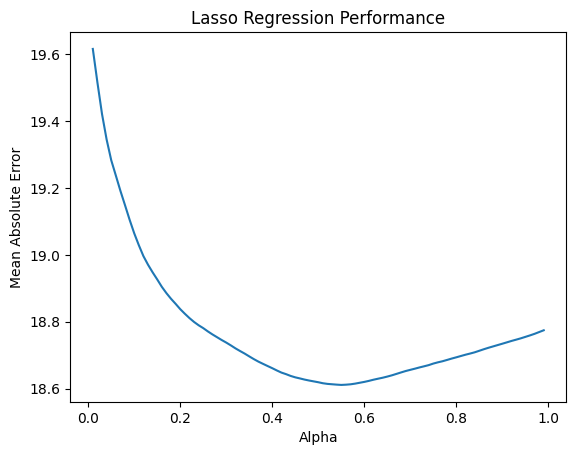

    alpha      error
54   0.55  18.610949


In [ ]:


alpha = []
error = []


for i in range(1, 100):
    alpha_value = i / 100
    alpha.append(alpha_value)
    
    pipeline = make_pipeline(StandardScaler(), Lasso(alpha=alpha_value))
    
    score = np.mean(cross_val_score(pipeline, x,y, scoring='neg_mean_absolute_error', cv=3))
    
    error.append(-score)

# graph error vs alpha
plt.plot(alpha, error)
plt.xlabel("Alpha")
plt.ylabel("Mean Absolute Error")
plt.title("Lasso Regression Performance")
plt.show()

# df with resutls
df_err = pd.DataFrame(zip(alpha, error), columns=['alpha', 'error'])

# getting the best alpha
best_alpha = df_err[df_err.error == min(df_err.error)]
print(best_alpha)


## Random forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:

RF=RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
scores = cross_val_score(RF, x, y, scoring='neg_mean_absolute_error', cv=kfold)
mae = -scores.mean()

print(mae)

11.85614162162162


## tune with gridsearchcv


In [15]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {
    "n_estimators": list(range(10, 150, 10)), 
    "criterion": ["absolute_error", "squared_error"],  
    "max_features": [None, "sqrt", "log2"]  
}

gr = GridSearchCV(RF, parameters, scoring="neg_mean_absolute_error", cv=3, n_jobs=-1)
gr.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_estimators=50, n_jobs=-1,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['absolute_error', 'squared_error'],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140]},
             scoring='neg_mean_absolute_error')

## test rf_tuned vs original

In [25]:
rf_tuned = gr.best_estimator_

cv_original = cross_val_score(RF, x, y, cv=5, scoring='neg_mean_absolute_error').mean()
cv_tuned = cross_val_score(rf_tuned, x, y, cv=5, scoring='neg_mean_absolute_error').mean()

print(f"MAE original: {-cv_original}")
print(f"MAE tuned: {-cv_tuned}")

MAE original: 13.072750408126245
MAE tuned: 13.117743263397625
